# Moview Review - Natural Language Processing

<center><img src="https://ninjaessays.us/wp-content/uploads/2018/05/movie-review-1.jpg" width="80%"></center>

In this notebook we analyze a dataset with movie reviews on their sentiments, to later predict sentiments on an unknown dataset of movie reviews. 

For the whole process of sentiment analysis we

1. setup the Dataframe,
2. create all the functions for the analyzer,
3. create our preferred model,
4. visualize the process, and finally
5. try some other variants of the classifier or vectorizer.

## Load & Clean & take a look at the DataFrame

In [1]:
%cd "/content/drive/My Drive/CoderSchool/NLP - Week 5"
!pwd

/content/drive/My Drive/CoderSchool/NLP - Week 5
/content/drive/My Drive/CoderSchool/NLP - Week 5


In [0]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv("/content/drive/My Drive/FTMLE - Tonga/Data/movie_review.csv", sep="\t")
df_eval = pd.read_csv("/content/drive/My Drive/FTMLE - Tonga/Data/movie_review_evaluation.csv", sep="\t")

In [4]:
df.sample(1)

,id,review,sentiment
16774,8913_9,This is my favorite classic. It was filmed a l...,1


First, let's drop the Id column, since it's not adding any value for our prediction. 

In [0]:
df.drop(['id'],axis=1,inplace=True)
df_eval.drop(['id'],axis=1,inplace=True)

In [6]:
sample_pos = df.head(10).values[0]
sample_pos

array(["With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it fina

In [7]:
sample_neg = df.head(10).values[2]
sample_neg

array(["The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like Â¨Jurassik ParkÂ¨, and some scientists resurrect one of nature's most fearsome predators, the Sabretooth tiger or Smilodon . Scientific ambition turns deadly, however, and when the high voltage fence is opened the creature escape and begins savagely stalking its prey - the human visitors , tourists and scientific.Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large pre-historical animals which are deadlier and bigger . In addition , a security agent (Stacy Haiduk) and her mate (Brian Wimmer) fight hardly against the carnivorous Smilodons. The Sabretooths, themselves , of course, are the real star stars and they are astounding terrifyingly though not convincing. The giant animals savagely are stalking its prey and the group run afoul and fight a

## Creating custom functions for the Analyzer
To use the sklearn Tfidf Vectorizer properly, we want to supply it with

- stop words,
- a preprocessor and
- a tokenizer.

###### First the **stop words**, ...

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

###### ... then the **preprocessor**, ...

In [9]:
!pip install unidecode

     |████████████████████████████████| 245kB 2.8MB/s 


In [0]:
import re
import unidecode
from nltk.corpus import stopwords

def preprocessor(sentence, neg_sub=True):
  """ 
  Remove HTML markup, modify emoticons and removes stop words
  (nltk stopwords have to be downloaded)
  """
  # Normalize
  # e.g.: Ä   ->    A
  sentence = unidecode.unidecode(sentence)
  
  # Save emoticons for later appending
  # e.g.: :)
  emoticons = re.findall('(?::|;|=|x|X)(?:-)?(?:\)|\(|D|P|O)', sentence)
  
  # Remove stop words and make everything lowercase
  # e.g.: This is a great idea!   ->    this is great idea!
  stop = stopwords.words('english')
  sentence = ' '.join([word for word in sentence.lower().split() if word not in stop])

  # Remove HTML markup
  # e.g.: <div>Hello</div>    ->    Hello
  sentence = re.sub('<[^>]*>', '', sentence)
    
  # Spell out negation abbreviations 
  # e.g.: n't   ->    not 
  sentence = re.sub("n't", ' not', sentence)
  
  # Remove any non-word character and append the emoticons without nose
  # e.g.: "this > is stupid. :-)    ->   this is stupid :)
  sentence = (re.sub('[\W]+', ' ', sentence + ' ' + ''.join(emoticons).replace('-', '')))
  
  # remove all lonely chars that got chopped off from plural or possessives
  # e.g.: i think it s a miracle why there are still lonely letters
  #       ->    
  #       think it miracle why there are still lonely letters
  sentence = ' '.join([word for word in sentence.split() if len(word)>1])

  # substitute selected words with their antonym
  if neg_sub:
    sentence = re.sub('not good', 'bad', sentence)
    sentence = re.sub('not bad', 'good', sentence)
    sentence = re.sub('not great', 'bad', sentence)
    sentence = re.sub('not funny', 'stupid', sentence)
    
  return sentence

###### ... and then finally the **Tokenizer**.
Important to note is, that we use lemmatization instead of stemming, since it promises are more accurate result (than just chopping off endings).


<center><img src="https://devopedia.org/images/article/227/6785.1570815200.png" width="40%" align="center"/></center>


Since NLTK is a leading platform for building Python programs to work with human language data, we used it to lemmatize our text.

In [11]:
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet') # reader for text files (https://www.nltk.org/howto/wordnet.html)
nltk.download('averaged_perceptron_tagger') # contains the pre-trained Part-of-Speech (https://en.wikipedia.org/wiki/Part_of_speech) tagger
nltk.download('punkt') #  divides a text into a list of sentences

def treebank_to_wordnet_pos(treebank_tag):
  """
  Converts from wordnet penns treebank tags to wordnet tags:
  In: treebank tags           (from https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)
  Out: NOUN, VERB, ADJ, ADV   (from http://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html)
  If not recognizable return NOUN
  """
  if treebank_tag.startswith('J'):
      return wn.ADJ
  elif treebank_tag.startswith('V'):
      return wn.VERB
  elif treebank_tag.startswith('R'):
      return wn.ADV
  else:
      return wn.NOUN

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
def tokenizer_nltk(sentence):
  tokens = nltk.word_tokenize(sentence)

  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(word, treebank_to_wordnet_pos(tag)) for word, tag in pos_tag(tokens)]

###### (and an alternative Lemmatizer from spacy, to see which one turns out to be better)

In [0]:
import spacy 

spacy.load('en')
lemmatizer = spacy.lang.en.English()

def tokenizer_spacy(sentence):
    tokens = lemmatizer(sentence)
    return([token.lemma_ for token in tokens])

## Creating the Model

###### Creating the vectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer( 
                              lowercase=True,               # lower case all words
                              preprocessor=preprocessor,    # remove special characters and stop words
                              tokenizer=tokenizer_nltk,     # part into tokens and lemmatize
                              ngram_range = (1, 3),         # get more word context with range
                              max_df=1.0,                   # ignore terms that have a document frequency higher than 100% of the documents
                              min_df=10                      # ignore terms that have a document frequency lower than 0 documents
                                                            #   note that no individual movie has more than 30 reviews 
                             )

###### Set X, y


In [0]:
X = df['review']
y = df['sentiment']

###### Split the data
Now we have to **split** into training and testing data. If this is the final training step, set final to true.


In [0]:
final=False

In [0]:
from sklearn.model_selection import train_test_split

if not final:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
else:
  # y_test is not relevant or valid, prevents crash
  X_train, X_test, y_train, y_test = X, df_eval['review'], y, y

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([('vect', vectorizer),
                ('clf', LogisticRegression(
                    #penalty='elasticnet',
                    #solver='saga',
                    #l1_ratio=1,
                    random_state=0
                    ))],
                verbose=True
               )

clf.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 2) Processing vect, total= 3.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.1s


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=10, ngram_range=(1, 3), norm='l2',
                                 preprocessor=<function preprocessor at 0x7f9dfb106048>,
                                 smooth_idf=True, stop_words=None,
                                 strip_accents=None,...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenizer_nltk at 0x7f9dfb106b70>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
              

In [0]:
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report

predictions = clf.predict(X_test)

In [20]:
if not final:
  # Show metrics
  print("Accuracy Score: %f" % accuracy_score(y_test, predictions))
  print("Mean Squared Error: %f" % mean_squared_error(y_test, predictions))
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, predictions))
  print(classification_report(y_test, predictions))

Accuracy Score: 0.887778
Mean Squared Error: 0.112222
Confusion Matrix:
[[1923  255]
 [ 250 2072]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2178
           1       0.89      0.89      0.89      2322

    accuracy                           0.89      4500
   macro avg       0.89      0.89      0.89      4500
weighted avg       0.89      0.89      0.89      4500



Lastly we save our model and, in case, our predictions.

In [0]:
import pickle
import os

pickle.dump(clf, open(os.path.join('MovieReviewModel_LR_TobiasBecher.pkl'), 'wb'))

In [0]:
#model = pickle.load(open('logisticRegression.pkl', 'rb'))

In [0]:
if final:
  #predictions.to_csv('tobiasbecher_pred_only.csv', sep='\t')
  df_eval['prediction']=predictions
  df_eval.to_csv('tobiasbecher.csv', sep='\t')

## Taking a closer look
Let's examine the process now more closely.
We want to create examples to illustrate the inner workings of our vectorizer, the analytical functions we wrote for it, and the model.
Basically we take everything apart to see if all the parts are working as they should and to see what we can improve.

### Building Test DataFrame

In [0]:
# Copy df for testing
# X
df_test = pd.DataFrame(X_test)
# y true
df_test['sentiment_truth'] = y_test
# y predicted
df_test['sentiment_prediction'] = predictions

# X all positive sentiments
df_test_pos = df_test[df_test['sentiment_truth']==1]
# X all negative sentiments
df_test_neg = df_test[df_test['sentiment_truth']==0]

# Predictions that the model got wrong
predictions_wrong = df_test[df_test['sentiment_truth']!=df_test['sentiment_prediction']]

In [25]:
# Check if df_test mirrors accuracy score is thus more likely to be assembled correctly
df_test[df_test['sentiment_truth']==df_test['sentiment_prediction']].count()/df_test.shape[0]

review                  0.887778
sentiment_truth         0.887778
sentiment_prediction    0.887778
dtype: float64

### Helper Functions for Visualization

In [0]:
example = predictions_wrong.iloc[0]

###### Visualizing Vectors
Preprocessing, Tokenization, Ngrams

In [0]:
# Creating example vectorized bag

# To show one example we use the same vectorizer, but without max_df and min_df
vectorizer_example = TfidfVectorizer( 
                              lowercase=True,               # lower case all words
                              preprocessor=preprocessor,    # remove special characters and stop words
                              tokenizer=tokenizer_nltk,     # part into tokens and lemmatize
                              ngram_range = (1, 3),         # Get more word context with range 3
                              #max_df=0.7,                  ONLY COMMENTED FOR EXAMPLE
                              #min_df=10                    ONLY COMMENTED FOR EXAMPLE
                             )

bag_example = vectorizer_example.fit_transform([example['review']])
bag_example = dict(zip(vectorizer_example.get_feature_names(), bag_example.toarray()[0]))
"""
bag_example = 
{'10': 0.05616559563017304,
 '10 respectively': 0.05616559563017304,
 '14': 0.05616559563017304,
 '14 last': 0.05616559563017304,
 '14 last time': 0.05616559563017304,
 '15': 0.11233119126034607,
 ...
}
"""

# Simulating the processing of the vectorizer
# preprocessing (and deleting stop words)
processed = [word for word in preprocessor(example['review'], neg_sub=False).split()]
# tokenizing
processed = [tokens for tokens in tokenizer_nltk(' '.join(processed))]
# building ngrams
vectorized = []
for i in range(len(processed)-2):
  vectorized.append(processed[i])
  vectorized.append(processed[i] + ' ' + processed[i+1])
  vectorized.append(processed[i] + ' ' + processed[i+1] + ' ' + processed[i+2])

In [0]:
import altair as alt

# Convert this to columnar data expected by Altair
x = [i for i in range(len(vectorized))]
y = vectorized
z = [bag_example[ngram] for ngram in vectorized]

source = pd.DataFrame({'x': x,  # Index in text
                     'y': y,    # ngrams 
                     'z': z})   # TfiDf of ngram

# only the most important
source_important = source[source['z']>=source['z'].quantile(q=0.90)]

# Charting TfiDf
heatmap = alt.Chart(source_important).mark_rect().encode(
            x='x:O',
            y='y:O',
            color=alt.Color('z:Q')
          )

# Configure text
chart_text = heatmap.mark_text(baseline='middle').encode(
    text='y:O',
    color=alt.condition(
        alt.datum.z > 0,
        alt.value('black'),
        alt.value('white')
    )
)

###### Negations
We want to see if it makes sense to substitute negations for antonyms to get a more coherent picture. E.g. I'm not a bad man. --> I'm a good man.

Since Antonyms are context dependent, we have to progress with caution and only substitute a few words. E.g. "I'm active." != "I'm extinct." even though extinct is an antonym of active. 

The idea is to hand the data to a TF vectorizer, with our preprocessor and new custom lemmatizer that excludes all words, that are no adjectives. 

Then we pick the most common adjectives in positive and negative and substitute their negations with the closest antonym.

In [0]:
# Find the most common adjectives in the testing df
def tokenizer_nltk_ADJ_only(sentence):
  tokens = nltk.word_tokenize(sentence)
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(word, wn.ADJ) for word, tag in pos_tag(tokens) if tag.startswith('J')]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

def get_most_common_words(corpus):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus. Default n=10.
    """
    count = CountVectorizer(lowercase=True,                   # lower case all words
                           preprocessor=preprocessor,         # remove special characters and stop words
                           tokenizer=tokenizer_nltk_ADJ_only  # lemmatizes and removes all non adjectives
                           )
    bag = count.fit_transform(corpus)
    sum_words = bag.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in count.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [31]:
common_adj_pos = get_most_common_words(df_test_pos['review'])
common_adj_neg = get_most_common_words(df_test_neg['review'])

print('The most common adjectives in positive sentiments are:\n', common_adj_pos[:30], '\n')
print('The most common adjectives in negative sentiments are:\n', common_adj_neg[:30], '\n')

The most common adjectives in positive sentiments are:
 [('good', 1610), ('great', 1271), ('many', 662), ('best', 651), ('little', 607), ('much', 575), ('young', 554), ('old', 539), ('new', 443), ('first', 434), ('big', 416), ('real', 415), ('bad', 394), ('funny', 304), ('true', 283), ('last', 276), ('beautiful', 271), ('excellent', 271), ('different', 256), ('original', 251), ('high', 250), ('wonderful', 230), ('small', 230), ('american', 227), ('whole', 221), ('nice', 210), ('hard', 207), ('classic', 205), ('black', 200), ('fine', 193)] 

The most common adjectives in negative sentiments are:
 [('bad', 1777), ('good', 1461), ('much', 612), ('little', 511), ('great', 502), ('many', 476), ('old', 413), ('big', 395), ('funny', 390), ('first', 383), ('real', 352), ('original', 314), ('young', 298), ('new', 295), ('whole', 294), ('least', 287), ('poor', 278), ('best', 256), ('low', 234), ('stupid', 229), ('last', 223), ('terrible', 220), ('dead', 219), ('awful', 219), ('sure', 205), ('har

In [32]:
# https://www.nltk.org/howto/wordnet.html
# Look at the antonyms of interesting words from both sentiment groups
#'good',  
#'bad',
#'great',
#'funny'

# change ideas based on the most common words
print('good <->', wn.synsets('good', pos='a')[0].lemmas()[0].antonyms()[0].name(), '\tchange suggestions: not good \t--> bad')
print('bad <->', wn.synsets('bad', pos='a')[0].lemmas()[0].antonyms()[0].name(), '\tchange suggestions: not bad \t--> good')
print('great <->', wn.synsets('great', pos='a')[0].lemmas()[0].antonyms(), '\tchange suggestions: not great \t--> bad')
print('funny <->', wn.synsets('funny', pos='a')[0].lemmas()[0].antonyms(), '\tchange suggestions: not funny \t--> stupid')


good <-> bad 	change suggestions: not good 	--> bad
bad <-> good 	change suggestions: not bad 	--> good
great <-> [] 	change suggestions: not great 	--> bad
funny <-> [] 	change suggestions: not funny 	--> stupid


In [0]:
def negation_substitute(sentence):
  sentence = re.sub('not good', 'bad', sentence)
  sentence = re.sub('not bad', 'good', sentence)
  sentence = re.sub('not great', 'bad', sentence)
  sentence = re.sub('not funny', 'stupid', sentence)
  return sentence

###### Printing

In [0]:
# Make it easier to read
def prettify(text: str) -> str:
  return ' ' + ' '.join([word if i%20 or i==0 else word+'\n' for i, word in enumerate(text.split())])

In [0]:
pretty_source = prettify(example['review'])

pretty_preprocessed = prettify(preprocessor(example['review']))

pretty_negation_substituted = negation_substitute(preprocessor(example['review'], neg_sub=False)).split()
for i in range(len(pretty_negation_substituted)):
  if pretty_negation_substituted[i] == 'good':
    pretty_negation_substituted[i] = '\033[93m'+'good'+'\033[0m'
  elif pretty_negation_substituted[i] == 'bad':
    pretty_negation_substituted[i] = '\033[93m'+'bad'+'\033[0m'
  elif pretty_negation_substituted[i] == 'great':
    pretty_negation_substituted[i] = '\033[93m'+'great'+'\033[0m'
  elif pretty_negation_substituted[i] == 'funny':
    pretty_negation_substituted[i] = '\033[93m'+'funny'+'\033[0m'
pretty_negation_substituted = prettify(' '.join(pretty_negation_substituted))

pretty_tokens = prettify("', '".join(vectorizer_example.get_feature_names()))
pretty_tokens = " '" + pretty_tokens[1:900] + "..."

### Visualized Analysis

In [36]:
print(predictions_wrong.shape[0], 'wrong predictions from', predictions.shape[0], 'entries, which equals', round((predictions_wrong.shape[0]/predictions.shape[0])*100,2), '%.\nBelow you will find a sample from the wrong predictions.\n' )

505 wrong predictions from 4500 entries, which equals 11.22 %.
Below you will find a sample from the wrong predictions.



In [37]:
#Visualize
print("\033[1m" + 'Truth:' + "\033[0m", example['sentiment_truth'])
print("\033[1m" + 'Prediction:' + "\033[0m", example['sentiment_prediction'])
print("\033[1m" + 'Review:\n' + "\033[0m" + pretty_source,'\n')
print("\033[1m" + 'Review after Preprocessing:\n' + "\033[0m" + pretty_preprocessed,'\n')
print("\033[1m" + 'Review after substituting:\n' + "\033[0m" + pretty_negation_substituted,'\n')
print("\033[1m" + 'Review after building tokens (included lemmatization) (excerpt):\n' + "\033[0m" + pretty_tokens,'\n')
print("\033[1m" + 'Review after TfiDf with the highest frequencies:\n' + "\033[0m")

# Draw the chart
heatmap + chart_text

Truth: 0
Prediction: 1
Review:
 This film was made in Saskatchewan and Manitoba Parks and returned the world eye again to what little of the \Wild
 Western Canada\" is left. When Archie began to write his stories for the papers; the thought of the day was
 to tame the wilderness and convert/absorb the First Nation Peoples.<br /><br />The film puts forward and asks the question; why
 would a well-educated, obviously talented Englishman become an Indian?<br /><br /> Archie, as an English boy dreams about becoming something
 but grasping the full meaning of that dream is unique and priceless - no mater what it is. Sounds like
 a famous puppet story doesn't it.<br /><br /> In my opinion, I saw Archie become my living image of the
 \"Cigar store Indian\" a very wooden character and not real at all - very well done acting on the part
 of Mr. Brosnan. He also portrayed the wild Indian in the dance scene for the tourist. The fullness and or
 reality of it weren't realized till he met and marri

alt.LayerChart(...)

### Optimization

1. LogisticRegression

- Solver 
> Which solving algorithm creates the best result?<br>
> Programmatically tested: **indifferent**

- Penalty     
> Which Error function should be used, l1 or l2?<br>
> Manually tested: **l2**

2. Vectorizer

- tokenizer_nltk, tokenizer_spacy     
> Which ones creates better tokens?<br>
> Manually tested: **tokenizer_nltk**

- $1 \leq \text{ngram_range} \leq 5$
> Which range of combined tokens is the right one?<br>
> Programmatically tested: **(1,1)**

- $0.5 \leq \text{max_df} \leq 1$
> Should there be a highest frequency rate?<br>
> Manually tested: **1**

- $0 \leq \text{min_df} \leq 100$
> Should there be a lowest frequency rate?<br>
> Programmatically tested: **0**






#### Logistic Regression Model

In [0]:
# Baseline LR
y_pred = predictions

In [39]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8876271524263067

In [40]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
train_results = []
test_results = []

for solver in solvers:
  lr = Pipeline([('vect', vectorizer),
                ('clf', LogisticRegression(
                    solver=solver,
                    n_jobs=-1,
                    random_state=0
                    ))],
                verbose=True
               )
  lr.fit(X_train, y_train)
  train_pred = lr.predict(X_train)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results.append(roc_auc)

  y_pred = lr.predict(X_test)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results.append(roc_auc)

[Pipeline] .............. (step 1 of 2) Processing vect, total= 3.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.1s
[Pipeline] .............. (step 1 of 2) Processing vect, total= 3.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 2) Processing vect, total= 3.3min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.6s
[Pipeline] .............. (step 1 of 2) Processing vect, total= 3.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.7s
[Pipeline] .............. (step 1 of 2) Processing vect, total= 3.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.9s


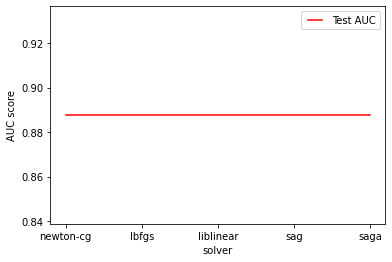

In [44]:
from matplotlib.legend_handler import HandlerLine2D

#line1, = plt.plot(solvers, train_results, 'b', label="Train AUC")
line1, = plt.plot(solvers, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('solver')
plt.show()

#### Vectorizer

In [0]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor)

In [0]:
X = df['review']
y = df['sentiment']

In [0]:
if not final:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
else:
  # y_test is not relevant or valid, prevents crash
  X_train, X_test, y_train, y_test = X, df_eval['review'], y, y

In [48]:
clf = Pipeline([('vect', vectorizer),
                ('clf', LogisticRegression(random_state=0))],
                verbose=True
               )

clf.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 2) Processing vect, total=  15.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.0s


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=<function preprocessor at 0x7f9dfb106048>,
                                 smooth_idf=True, stop_words=None,
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    f

In [0]:
# Baseline
y_pred = clf.predict(X_test)

In [50]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8889903260939201

###### Ngrams

In [51]:
ngrams = [(1,1), (1,2), (1,3), (1,4), (1,5), (2,3), (2,4)]
train_results = []
test_results = []

for ngram in ngrams:

  vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                               ngram_range=ngram)

  lr = Pipeline([ ('vect', vectorizer),
                  ('clf', LogisticRegression(n_jobs=-1, random_state=0))],
                  verbose=True)
  lr.fit(X_train, y_train)
  train_pred = lr.predict(X_train)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results.append(roc_auc)

  y_pred = lr.predict(X_test)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results.append(roc_auc)

[Pipeline] .............. (step 1 of 2) Processing vect, total=  15.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.3s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  27.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  14.1s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  44.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  30.9s
[Pipeline] .............. (step 1 of 2) Processing vect, total= 1.0min
[Pipeline] ............... (step 2 of 2) Processing clf, total=  22.7s
[Pipeline] .............. (step 1 of 2) Processing vect, total= 1.2min
[Pipeline] ............... (step 2 of 2) Processing clf, total=  18.3s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  40.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   8.9s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  56.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  20.2s


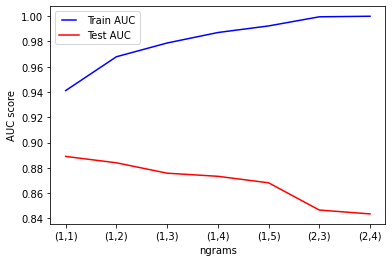

In [52]:
ngrams = ['(1,1)', '(1,2)', '(1,3)', '(1,4)', '(1,5)', '(2,3)', '(2,4)']
line1, = plt.plot(ngrams, train_results, 'b', label="Train AUC")
line2, = plt.plot(ngrams, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('ngrams')
plt.show()

###### Minimum Document Frequency

In [53]:
min_dfs = [0, 5, 10, 20, 30, 50, 100, 2250, 6750] # the latter are 10% and 30%
train_results = []
test_results = []

for min_df in min_dfs:

  vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                               min_df=min_df)

  lr = Pipeline([ ('vect', vectorizer),
                  ('clf', LogisticRegression(n_jobs=-1, random_state=0))],
                  verbose=True)
  lr.fit(X_train, y_train)
  train_pred = lr.predict(X_train)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results.append(roc_auc)

  y_pred = lr.predict(X_test)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results.append(roc_auc)

[Pipeline] .............. (step 1 of 2) Processing vect, total=  15.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.6s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  15.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  15.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.6s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  15.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.7s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  15.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  15.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.5s
[Pipeline] .............. (step 1 of 2) Processing vect, total=  15.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.6s
[Pipel

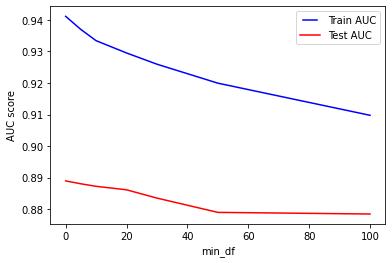

In [54]:
line1, = plt.plot(min_dfs[:7], train_results[:7], 'b', label="Train AUC")
line2, = plt.plot(min_dfs[:7], test_results[:7], 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min_df')
plt.show()

Now we can go back and adjust our model in the "Create Model" section.

## Different Approaches

#### Absolute Frequency 
Let's compare our vectorizer to a absolute frequency vectorizer.

In [0]:
count_vectorizer = CountVectorizer( 
                              lowercase=True,               # lower case all words
                              preprocessor=preprocessor,    # remove special characters and stop words
                              tokenizer=tokenizer_nltk,     # part into tokens and lemmatize
                              ngram_range = (1, 3),         # get more word context with range 3
                              #max_df=0.7,                   # ignore terms that have a document frequency higher than 70% of the documents
                              min_df=5                      # ignore terms that have a document frequency lower than 5 documents
                             )

If this is the final training step, set final to true.

In [0]:
X = df['review']
y = df['sentiment']

if not final:
  X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=0)
else:
  # y_test is not relevant or valid, prevents crash
  X_train, X_test, y_train, y_test = X, df_eval['review'], y, y

In [57]:
clf_count = Pipeline([('vect', count_vectorizer),
                ('clf', LogisticRegression(
                    #penalty='elasticnet',
                    #solver='saga',
                    #l1_ratio=1,
                    random_state=0,
                    max_iter=1000
                    ))
                ],
                verbose=True
               )

clf_count.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 2) Processing vect, total= 3.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total=   6.7s


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 3),
                                 preprocessor=<function preprocessor at 0x7f9dfb106048>,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenizer_nltk at 0x7f9dfb106b70>,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                  

In [0]:
predictions_count = clf_count.predict(X_test)

In [59]:
if not final:
  # Show metrics
  print("Accuracy Score: %f" % accuracy_score(y_test, predictions_count), "\t\tCompared to LogisticRegression Accuracy Score: %f" % accuracy_score(y_test, predictions))
  print("Mean Squared Error: %f" % mean_squared_error(y_test, predictions_count))
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, predictions_count))
  print(classification_report(y_test, predictions_count))

Accuracy Score: 0.884000 		Compared to LogisticRegression Accuracy Score: 0.887778
Mean Squared Error: 0.116000
Confusion Matrix:
[[1924  254]
 [ 268 2054]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2178
           1       0.89      0.88      0.89      2322

    accuracy                           0.88      4500
   macro avg       0.88      0.88      0.88      4500
weighted avg       0.88      0.88      0.88      4500



Lastly we save our model and, in case, our predictions.

In [0]:
pickle.dump(clf, open(os.path.join('MovieReviewModel_LR_count_TobiasBecher.pkl'), 'wb'))

In [0]:
#model = pickle.load(open('logisticRegression.pkl', 'rb'))

In [0]:
if final:
  #predictions.to_csv('tobiasbecher_pred_count.csv', sep='\t')
  df_eval['prediction']=predictions_count
  df_eval.to_csv('tobiasbecher_count.csv', sep='\t')

#### Random Forest Classifier
To have more context how well our Logistic Regression model performed we want to compare it to a Random Forest Classifier.

<center><img src="https://i2.wp.com/syncedreview.com/wp-content/uploads/2017/10/Screen-Shot-2017-06-10-at-11.11.43-AM.png?resize=1344%2C580&ssl=1" width="60%"></center>

##### Finding estimators and tree depth




Estimators(number of trees):
> Usually the higher the number of trees the better to learn the data. 

Depth(Tree size):
> The deeper the tree, the more splits it has and it captures more information about the data.


In [0]:
# vectorize first
X = vectorizer.fit_transform(df['review'])
y = df['sentiment']

In [0]:
# Split 
if not final:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
else:
  # y_test is not relevant or valid, prevents crash
  X_train, X_test, y_train, y_test = X, df_eval['review'], y, y

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Baseline RF
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [66]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5682423245848193

In [0]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
  rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1, random_state=0)
  rf.fit(X_train, y_train)
  train_pred = rf.predict(X_train)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results.append(roc_auc)

  y_pred = rf.predict(X_test)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results.append(roc_auc)

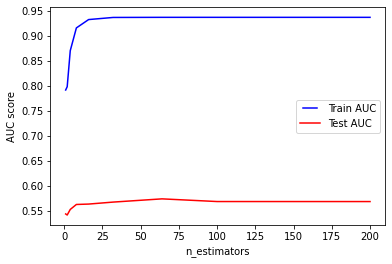

In [68]:
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [0]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
  rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, random_state=0)
  rf.fit(X_train, y_train)
  train_pred = rf.predict(X_train)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results.append(roc_auc)

  y_pred = rf.predict(X_test)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results.append(roc_auc)

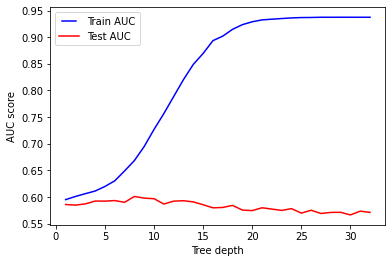

In [70]:
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

##### Create the RandomForest Model

Now that we know the best values for our estimators and tree depth we can use this in our real RF model.

In [71]:
RF_clf = RandomForestClassifier(n_estimators=40, max_depth=25, random_state=0)

RF_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [72]:
RF_predictions = RF_clf.predict(X_test)

# Show metrics
print("Accuracy Score: %f" % accuracy_score(y_test, RF_predictions), "\t\tCompared to LogisticRegression Accuracy Score: %f" % accuracy_score(y_test, predictions))
print("Mean Squared Error: %f" % mean_squared_error(y_test, RF_predictions), "\t\tCompared to LogisticRegression Mean Squared Error: %f" % mean_squared_error(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, RF_predictions))
print(classification_report(y_test, RF_predictions))

Accuracy Score: 0.571556 		Compared to LogisticRegression Accuracy Score: 0.887778
Mean Squared Error: 0.428444 		Compared to LogisticRegression Mean Squared Error: 0.112222
Confusion Matrix:
[[1237  941]
 [ 987 1335]]
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      2178
           1       0.59      0.57      0.58      2322

    accuracy                           0.57      4500
   macro avg       0.57      0.57      0.57      4500
weighted avg       0.57      0.57      0.57      4500



In [0]:
pickle.dump(clf, open(os.path.join('MovieReviewModel_RF_TobiasBecher.pkl'), 'wb'))